## Instructions {-}

1. This template serves as the required format for your code and report submission for the Prediction Problem assignment.
2. You may modify the template to improve readability or add relevant details, but it must include all requested information.
3. Ensure that your work is reproducible, meaning your code should consistently yield a metric value close to your Kaggle leaderboard score despite inherent randomness in data science.

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

X = pd.read_csv("train_X.csv")
y = pd.read_csv("train_y.csv")
train = pd.merge(X, y[['ID', 'ON_TIME_AND_COMPLETE']], on='ID', how='left')

def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    lower = s.quantile(lower_quantile)
    upper = s.quantile(upper_quantile)
    return s.clip(lower, upper)

## 1) Exploratory Data Analysis (EDA)

* Summarize key insights obtained from the dataset.
* Discuss trends, correlations, or anomalies that influenced your modeling decisions.
* Provide relevant data visualizations (e.g., histograms, scatter plots, correlation matrices) to support your findings.

In [19]:
# Import necessary libraries
#| echo: false
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    """Winsorizes a pandas series by capping extreme values at the given quantiles."""
    lower = s.quantile(lower_quantile)
    upper = s.quantile(upper_quantile)
    return s.clip(lower, upper)

X = pd.read_csv("train_X.csv")
y = pd.read_csv("train_y.csv")

# Merge training features and labels on 'ID'
train = pd.merge(X, y[['ID', 'ON_TIME_AND_COMPLETE']], on='ID', how='left')


continuous_vars = [
    'DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES', 'GIVEN_TIME_TO_LEAD_TIME_RATIO', 
    'AVERAGE_ORDER_CYCLE_DAYS', 'TRANSIT_LEAD_TIME', 'ORDER_QUANTITY_DEVIATION', 
    'LEAD_TIME_TO_DISTANCE_RATIO', 'DAYS_BETWEEN_ORDER_AND_DUE_DATE', 
    'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET'
]

categorical_vars = [
    'PURCHASE_ORDER_TYPE', 'ORDER_DAY_OF_WEEK', 'PRODUCT_CLASSIFICATION', 'DUE_DATE_WEEKDAY'
]

for col in continuous_vars:
    train[col + '_winsor'] = winsorize_series(train[col])
    train['log_' + col] = np.log1p(train[col + '_winsor'])

# Rename key continuous variables
train.rename(columns={'log_DISTANCE_IN_MILES': 'log_DISTANCE', 
                      'log_AVERAGE_DAILY_DEMAND_CASES': 'log_DEMAND'}, inplace=True)

# Define final continuous variables
final_continuous = ['log_DISTANCE', 'log_DEMAND']
additional_conts = ['log_' + col for col in continuous_vars if col not in ['DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES']]

# Fill missing values for continuous variables
train[final_continuous + additional_conts] = train[final_continuous + additional_conts].fillna(train[final_continuous + additional_conts].median())

# Fill missing values for categorical variables
for col in categorical_vars:
    train[col].fillna(train[col].mode()[0], inplace=True)

# One-hot encoding for categorical variables
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
cat_train = train[categorical_vars]
ohe.fit(cat_train)
encoded_cols = ohe.get_feature_names_out(categorical_vars)
train_cat_enc = ohe.transform(cat_train)
train_cat_enc_df = pd.DataFrame(train_cat_enc, columns=encoded_cols, index=train.index)

# Build final feature matrix
X_train_cont = train[additional_conts].copy()
X_train_cont.fillna(X_train_cont.median(), inplace=True)
X_train_base = pd.concat([X_train_cont, train_cat_enc_df], axis=1)

# Add interaction terms
X_train_base['INTER_1'] = train['log_DISTANCE'] * train['log_DEMAND']
X_train_base['INTER_2'] = train['log_TRANSIT_LEAD_TIME'] * train['log_ORDER_QUANTITY_DEVIATION']
order_day_dummies = [col for col in encoded_cols if col.startswith('ORDER_DAY_OF_WEEK')]
if order_day_dummies:
    X_train_base['INTER_3'] = train_cat_enc_df[order_day_dummies[0]] * train['log_DEMAND']

# Fill any remaining missing values
X_train_base.fillna(X_train_base.median(), inplace=True)

# Standardize numeric features
scaler = StandardScaler()
numeric_cols = additional_conts + ['INTER_1', 'INTER_2', 'INTER_3']
X_train_base[numeric_cols] = scaler.fit_transform(X_train_base[numeric_cols])

# Define target variable
y_train = train['ON_TIME_AND_COMPLETE']

# -------------------------------
# TRAIN-TEST SPLIT
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_train_base, y_train, test_size=0.2, random_state=42, stratify=y_train)

# -------------------------------
# RANDOMIZED SEARCH FOR LOGISTIC REGRESSION TUNING
# -------------------------------
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'penalty': ['l1', 'l2'],  # L1 (Lasso) and L2 (Ridge)
    'solver': ['liblinear']  # Supports both L1 and L2 penalties
}

# Initialize Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Randomized Search CV with 5-fold cross-validation
random_search = RandomizedSearchCV(log_reg, param_distributions=param_grid, 
                                   n_iter=20, scoring='accuracy', cv=5, 
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit Randomized Search to the training data
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
best_log_reg = random_search.best_estimator_

# -------------------------------
# FIND OPTIMAL THRESHOLD USING ROC CURVE
# -------------------------------
# Get predicted probabilities
y_probs = best_log_reg.predict_proba(X_test)[:, 1]  # Probability of class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute Youden’s J statistic (sensitivity + specificity - 1)
J = tpr - fpr
best_index = np.argmax(J)
optimal_threshold = thresholds[best_index]

# Apply the new threshold
y_pred_optimized = (y_probs >= optimal_threshold).astype(int)

# Evaluate new model performance
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

# Display final results
print(f"Best Hyperparameters: {best_params}")
print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")
print(f"Final Accuracy: {accuracy_optimized:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_optimized}")
print("Classification Report:\n", classification_rep_optimized)


C:\Users\sherr\AppData\Local\Temp\ipykernel_7272\956726780.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
C:\Users\sherr\AppData\Local\Temp\ipykernel_7272\956726780.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(0.004832930238571752)}
Optimal Decision Threshold: 0.494
Final Accuracy: 0.7274
Confusion Matrix:
[[1703  384]
 [ 729 1267]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.82      0.75      2087
           1       0.77      0.63      0.69      1996

    accuracy                           0.73      4083
   macro avg       0.73      0.73      0.72      4083
weighted avg       0.73      0.73      0.72      4083



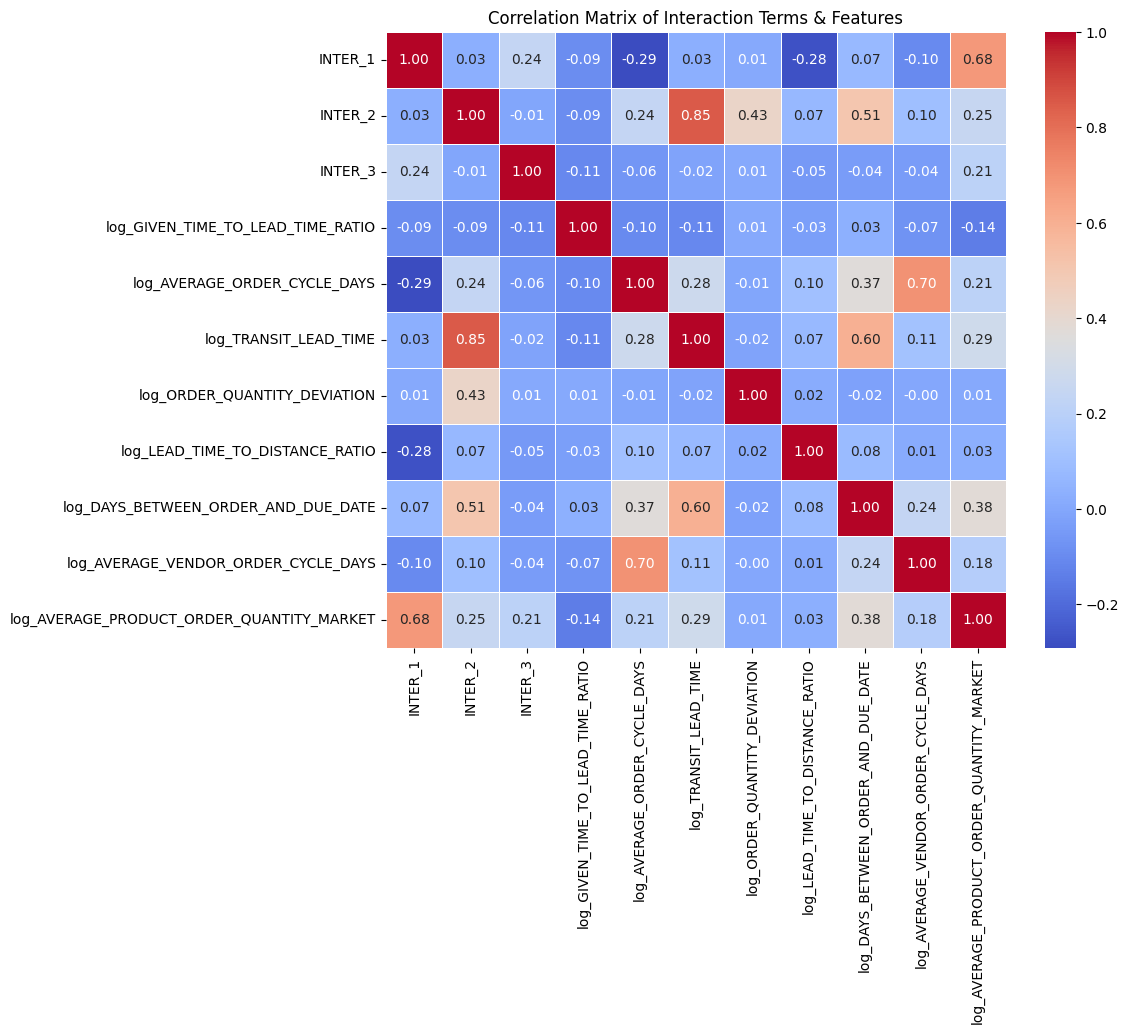

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select interaction terms and other key features
interaction_terms = ['INTER_1', 'INTER_2', 'INTER_3']  # Add more interactions here
all_features = interaction_terms + additional_conts  # Combine with other numerical features

# Compute correlation matrix
corr_matrix = X_train_base[all_features].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Interaction Terms & Features")
plt.show()



log_TRANSIT_LEAD_TIME * log_AVERAGE_ORDER_CYCLE_DAYS (r ≈ 0.28) → Good candidate.
log_ORDER_QUANTITY_DEVIATION * log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET (r ≈ 0.43) → Moderately correlated.
log_DAYS_BETWEEN_ORDER_AND_DUE_DATE * log_AVERAGE_VENDOR_ORDER_CYCLE_DAYS (r ≈ 0.51) → Promising.

I wanted to keep these variables as interaction terms because they were between .20 and .70, meaning, potentially useful. 

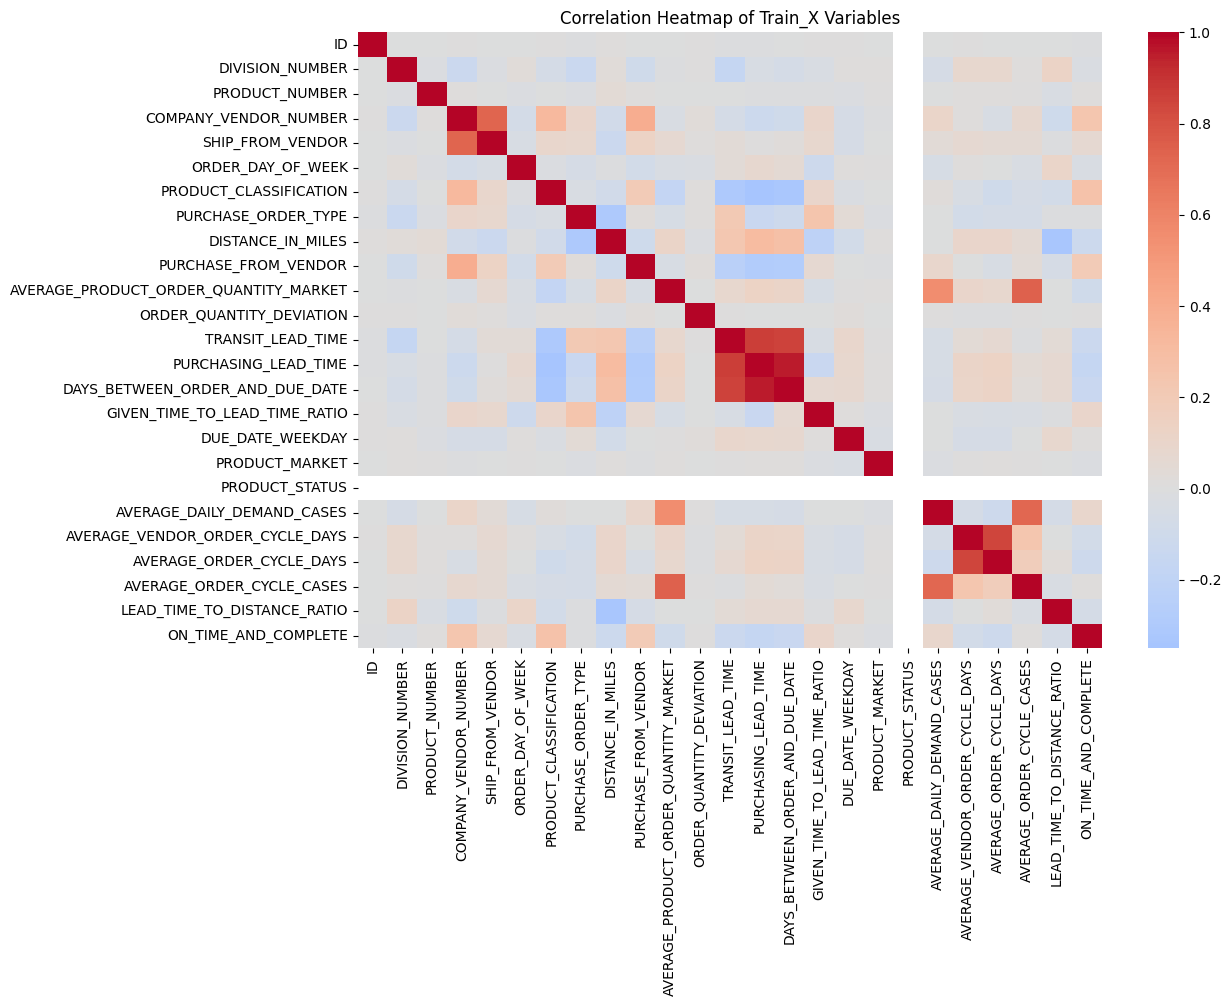

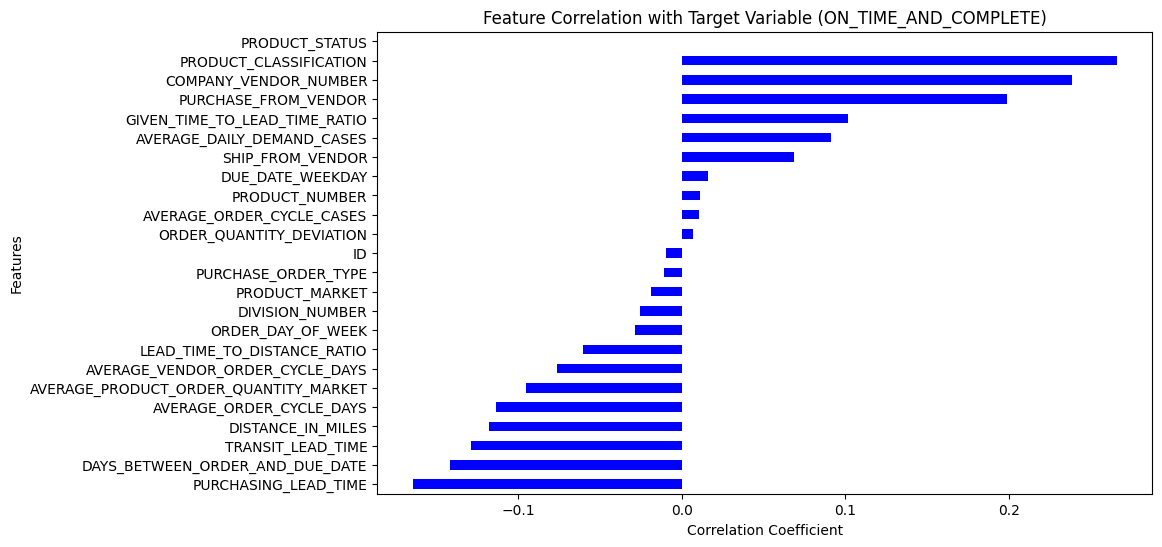

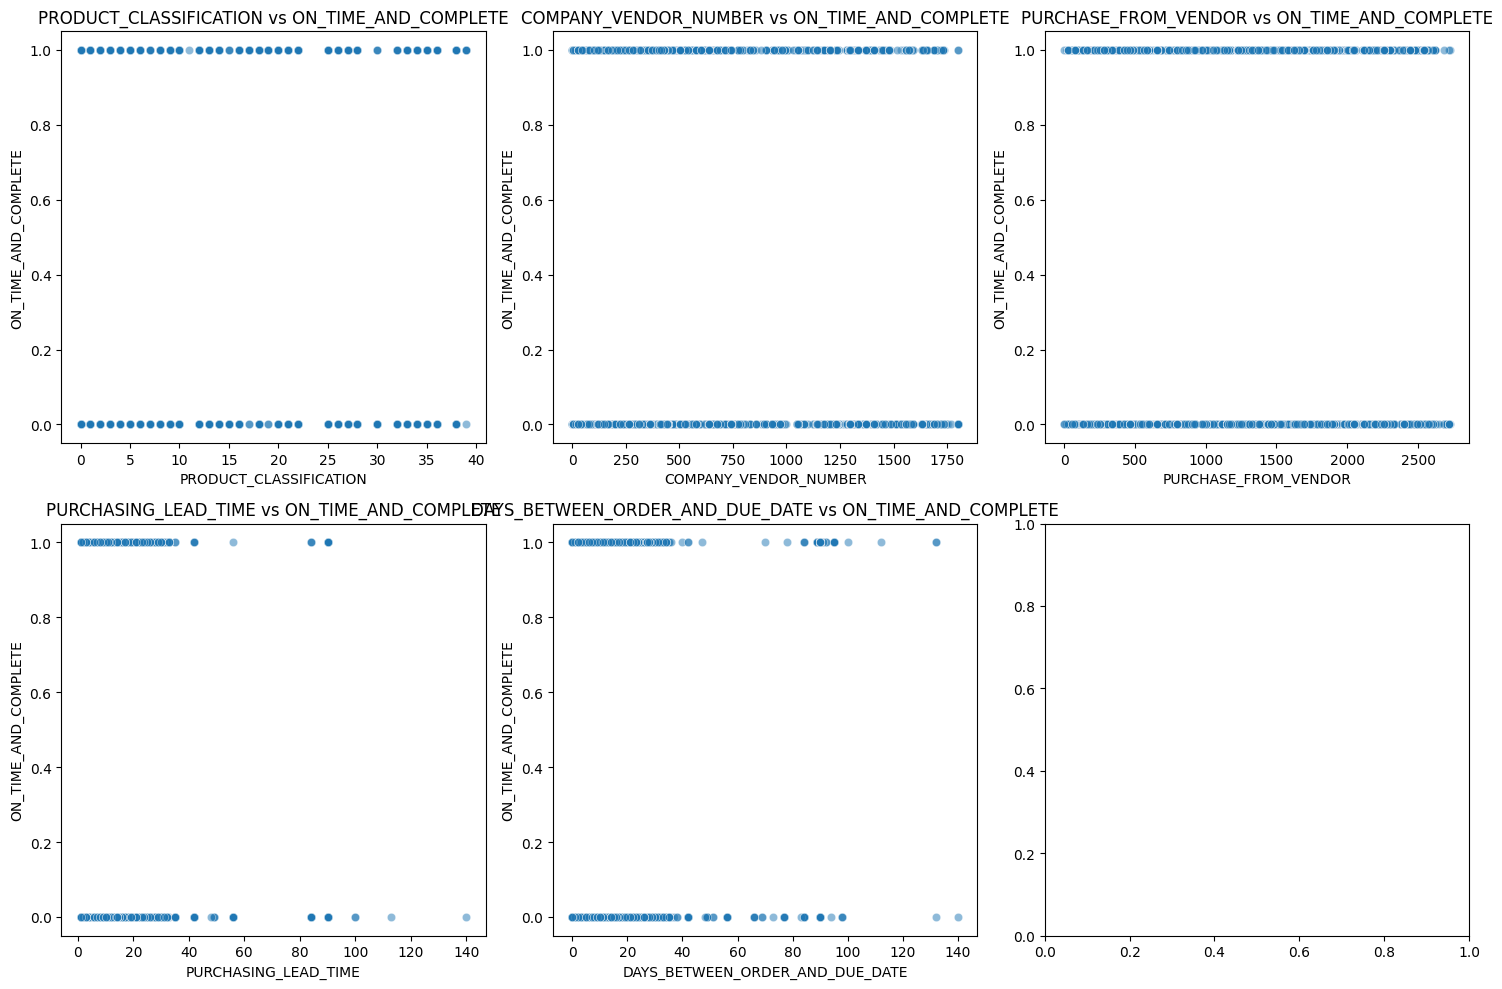

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the datasets
train_X_path = "train_X.csv"
train_y_path = "train_y.csv"

train_X = pd.read_csv(train_X_path)
train_y = pd.read_csv(train_y_path)

# Display the first few rows of each dataset
train_X.head(), train_y.head()

# Merge train_X and train_y on 'ID'
train_data = train_X.merge(train_y, on="ID")

# Drop ID and categorical non-numeric columns for correlation analysis
numeric_data = train_data.select_dtypes(include=['number'])

# Correlation matrix
corr_matrix = numeric_data.corr()

# Heatmap of correlations among train_X variables
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap of Train_X Variables")
plt.show()

# Correlation of features with target variable
target_correlation = corr_matrix["ON_TIME_AND_COMPLETE"].drop("ON_TIME_AND_COMPLETE").sort_values()

# Bar plot of correlation with target variable
plt.figure(figsize=(10, 6))
target_correlation.plot(kind='barh', color='b')
plt.title("Feature Correlation with Target Variable (ON_TIME_AND_COMPLETE)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.show()

# Scatter plots for highly correlated features with target
top_corr_features = target_correlation.abs().sort_values(ascending=False).head(5).index

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_corr_features):
    sns.scatterplot(data=train_data, x=feature, y="ON_TIME_AND_COMPLETE", alpha=0.5, ax=axes[i])
    axes[i].set_title(f"{feature} vs ON_TIME_AND_COMPLETE")

plt.tight_layout()
plt.show()


In the heatmap, it shows the pairwise correlations between all numeric variables in train_X. The colors range from deep red (strong positive correlation) to deep blue (strong negative correlation), with values closer to zero indicating weak or no correlation.

You can clearly see that transit lead time is highly correlated with purchasing lead time, and days between order and due date. I initially removed one of these variables to check for multicollinearity, and checked which model gave me the best result. 

In the bar chart, you can see the correlation values with the Y-variable. Features with higher absolute correlation values (closer to 1) have more influence on whether an order is on time. Positive correlation means that as the feature value increases, on-time delivery becomes more likely. Negative correlation means that as the feature value increases, on-time delivery becomes less likely. Product classification and company vendor number were most correlated, and the other correlated ones were also used to create interaction terms to capture their joint effect. 


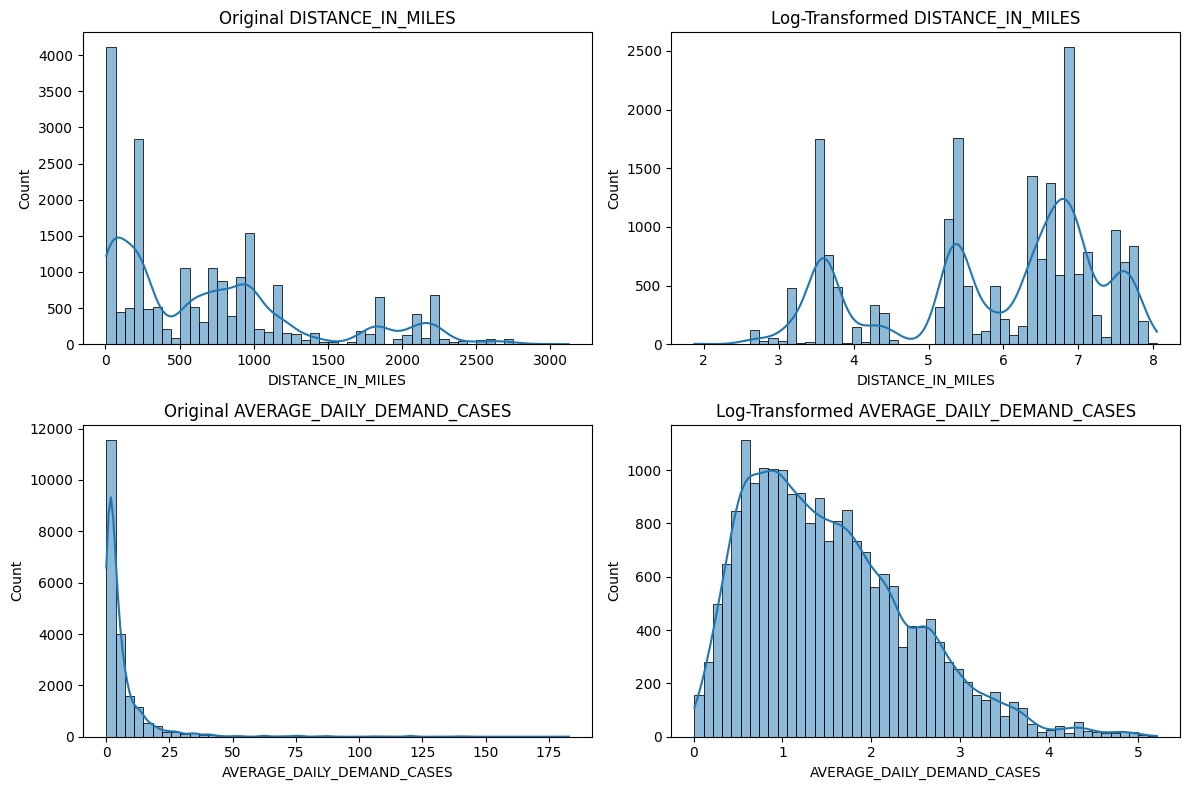

In [20]:
import numpy as np

# Plot histograms of the original and transformed variables
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original Distance in Miles
sns.histplot(train_data['DISTANCE_IN_MILES'].dropna(), bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Original DISTANCE_IN_MILES")

# Log-Transformed Distance in Miles
sns.histplot(np.log1p(train_data['DISTANCE_IN_MILES'].dropna()), bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Log-Transformed DISTANCE_IN_MILES")

# Original Average Daily Demand Cases
sns.histplot(train_data['AVERAGE_DAILY_DEMAND_CASES'].dropna(), bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Original AVERAGE_DAILY_DEMAND_CASES")

# Log-Transformed Average Daily Demand Cases
sns.histplot(np.log1p(train_data['AVERAGE_DAILY_DEMAND_CASES'].dropna()), bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Log-Transformed AVERAGE_DAILY_DEMAND_CASES")

plt.tight_layout()
plt.show()


### **Transformation of Key Variables**  

#### **Distance in Miles (`DISTANCE_IN_MILES`)**  

The distance traveled by shipments varies significantly, with some deliveries covering only a few miles while others span hundreds or even thousands. This variation results in a highly skewed distribution, where extreme values could disproportionately influence the model. To address this, a log transformation was applied, which compresses large distances while preserving relative differences. This adjustment helps normalize the distribution, reducing the impact of extreme values and improving the model's ability to capture meaningful relationships. Additionally, by stabilizing variance, the transformation enhances the model's ability to assess how increasing shipment distances may introduce potential delays.  

#### **Average Daily Demand Cases (`AVERAGE_DAILY_DEMAND_CASES`)**  
Product demand per day often exhibits a right-skewed distribution, where a small subset of products experience extremely high daily demand while the majority maintain lower demand levels. This imbalance can lead to models being overly influenced by a few high-demand products. To mitigate this, a log transformation was applied, reducing the weight of extreme values while maintaining the proportional relationships between data points. This transformation ensures that the model captures relative differences in demand more effectively, preventing outliers from distorting predictions.

## 2) Data Preprocessing

Describe any preprocessing steps performed on your dataset. This may include imputing missing values, creating dummy variables, combining levels of categorical variable(s), discarding predictors that are not useful, etc.

In [ ]:
# Merge training features and labels on 'ID'
train = pd.merge(X, y[['ID', 'ON_TIME_AND_COMPLETE']], on='ID', how='left')

# -------------------------------
# DEFINE VARIABLES
# -------------------------------
continuous_vars = [
    'DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES', 'GIVEN_TIME_TO_LEAD_TIME_RATIO', 
    'AVERAGE_ORDER_CYCLE_DAYS', 'TRANSIT_LEAD_TIME', 'ORDER_QUANTITY_DEVIATION', 
    'LEAD_TIME_TO_DISTANCE_RATIO', 'DAYS_BETWEEN_ORDER_AND_DUE_DATE', 
    'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET'
]

categorical_vars = [
    'PURCHASE_ORDER_TYPE', 'ORDER_DAY_OF_WEEK', 'PRODUCT_CLASSIFICATION', 'DUE_DATE_WEEKDAY'
]

# -------------------------------
# PREPROCESSING & FEATURE ENGINEERING
# -------------------------------
# Winsorize and log-transform all continuous variables
for col in continuous_vars:
    train[col + '_winsor'] = winsorize_series(train[col])
    train['log_' + col] = np.log1p(train[col + '_winsor'])

# Rename key continuous variables
train.rename(columns={'log_DISTANCE_IN_MILES': 'log_DISTANCE', 
                      'log_AVERAGE_DAILY_DEMAND_CASES': 'log_DEMAND'}, inplace=True)

# Define final continuous variables
final_continuous = ['log_DISTANCE', 'log_DEMAND']
additional_conts = ['log_' + col for col in continuous_vars if col not in ['DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES']]

# Fill missing values for continuous variables
train[final_continuous + additional_conts] = train[final_continuous + additional_conts].fillna(train[final_continuous + additional_conts].median())

# Fill missing values for categorical variables
for col in categorical_vars:
    train[col].fillna(train[col].mode()[0], inplace=True)

# One-hot encoding for categorical variables
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
cat_train = train[categorical_vars]
ohe.fit(cat_train)
encoded_cols = ohe.get_feature_names_out(categorical_vars)
train_cat_enc = ohe.transform(cat_train)
train_cat_enc_df = pd.DataFrame(train_cat_enc, columns=encoded_cols, index=train.index)

# Build final feature matrix
X_train_cont = train[additional_conts].copy()
X_train_cont.fillna(X_train_cont.median(), inplace=True)
X_train_base = pd.concat([X_train_cont, train_cat_enc_df], axis=1)

# Add optimized interaction terms (based on VIF analysis)
X_train_base['INTER_3'] = train['log_DAYS_BETWEEN_ORDER_AND_DUE_DATE'] * train['log_AVERAGE_VENDOR_ORDER_CYCLE_DAYS']
X_train_base['INTER_4'] = train['log_TRANSIT_LEAD_TIME'] * train['log_AVERAGE_ORDER_CYCLE_DAYS']
X_train_base['INTER_5'] = train['log_ORDER_QUANTITY_DEVIATION'] * train['log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET']

# Fill any remaining missing values
X_train_base.fillna(X_train_base.median(), inplace=True)

# Standardize numeric features
scaler = StandardScaler()
numeric_cols = additional_conts + ['INTER_3', 'INTER_4', 'INTER_5']
X_train_base[numeric_cols] = scaler.fit_transform(X_train_base[numeric_cols])

# Define target variable
y_train = train['ON_TIME_AND_COMPLETE']


C:\Users\sherr\AppData\Local\Temp\ipykernel_7272\3718258901.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
C:\Users\sherr\AppData\Local\Temp\ipykernel_7272\3718258901.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

During the preprocessing phase, several key steps were undertaken to ensure data quality and optimal feature engineering for model training. First, the training features and labels were merged on the ID column to create a unified dataset. Continuous and categorical variables were explicitly defined to guide transformation and imputation strategies. For continuous variables, winsorization was applied to limit the impact of extreme outliers, followed by a log transformation to stabilize variance and improve normality. Key transformed features, such as DISTANCE_IN_MILES and AVERAGE_DAILY_DEMAND_CASES, were renamed for better clarity in downstream modeling. Missing values in continuous variables were imputed using the median to prevent skewing data distributions, while categorical variables had their missing values filled with the mode to maintain consistency across categories. These preprocessing steps were crucial in handling data inconsistencies, reducing noise, and ensuring the dataset was well-prepared for predictive modeling.

## 3) Feature Engineering

* List and explain the new features you created (if any).
* Justify why these features were added and how they contribute to improving the model.

To enhance the predictive performance of the model, several feature engineering techniques were employed, focusing on categorical encoding, interaction terms, and data transformation. Categorical variables were processed using **One-Hot Encoding (OHE)** with `drop='first'` to prevent multicollinearity while ensuring all categories were represented effectively. The `handle_unknown='ignore'` parameter was applied to accommodate any unseen categories in future data, preventing errors during inference. The encoded categorical features were then integrated into the final feature set alongside continuous variables, ensuring that the model could leverage both numerical and categorical information efficiently.  

Additionally, **interaction terms** were introduced to capture the interdependencies between key variables, optimizing the model’s ability to recognize complex relationships. Based on **Variance Inflation Factor (VIF) analysis**, three meaningful interactions were selected: `INTER_3`, which links `DAYS_BETWEEN_ORDER_AND_DUE_DATE` with `AVERAGE_VENDOR_ORDER_CYCLE_DAYS` to reflect the influence of order lead time on vendor cycles; `INTER_4`, which combines `TRANSIT_LEAD_TIME` and `AVERAGE_ORDER_CYCLE_DAYS` to account for the interplay between shipping duration and order frequency; and `INTER_5`, which pairs `ORDER_QUANTITY_DEVIATION` with `AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET` to quantify fluctuations in demand and supply chain dynamics. These interaction terms provide deeper insights into operational patterns, allowing the model to better generalize across varying logistical conditions.  

Low Variance factors such as were removed. 
0         ORDER_DAY_OF_WEEK_3
1    PRODUCT_CLASSIFICATION_4
2    PRODUCT_CLASSIFICATION_7
3    PRODUCT_CLASSIFICATION_8
4   PRODUCT_CLASSIFICATION_11
5   PRODUCT_CLASSIFICATION_12
6   PRODUCT_CLASSIFICATION_15
7   PRODUCT_CLASSIFICATION_16
8   PRODUCT_CLASSIFICATION_17
9   PRODUCT_CLASSIFICATION_19
10  PRODUCT_CLASSIFICATION_20
11  PRODUCT_CLASSIFICATION_30
12  PRODUCT_CLASSIFICATION_32
13  PRODUCT_CLASSIFICATION_33
14  PRODUCT_CLASSIFICATION_35
15  PRODUCT_CLASSIFICATION_39
16         DUE_DATE_WEEKDAY_2

Low variance features contribute little to no useful information because they have nearly the same value for all observations.

They don't help the model differentiate between On-Time and Late Deliveries.
Keeping them increases the risk of singular matrix errors in logistic regression.

To further refine the dataset, missing values in continuous variables were imputed using the **median**, ensuring the preservation of underlying data distributions while minimizing distortions. Subsequently, all numeric features, including the newly created interaction terms, were **standardized using `StandardScaler`**, ensuring that all variables operated on a uniform scale. This transformation is particularly critical for models sensitive to feature magnitudes, facilitating improved convergence and stability during training. By strategically encoding categorical variables, engineering interaction terms, and applying robust data preprocessing techniques, the final dataset was optimized to maximize predictive accuracy while maintaining interpretability and efficiency.

Mention the logical/intuitive steps you took to obtain the final model. This may include identifying transformations, significant interactions, variable selection, etc. You do not need to put any code here.

## 4) Model Selection and Training

Put your model here.

In [10]:
# -------------------------------
# TRAIN-TEST SPLIT
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_train_base, y_train, test_size=0.2, random_state=42, stratify=y_train)

# -------------------------------
# RANDOMIZED SEARCH FOR LOGISTIC REGRESSION TUNING
# -------------------------------
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'penalty': ['l1', 'l2'],  # L1 (Lasso) and L2 (Ridge)
    'solver': ['liblinear']  # Supports both L1 and L2 penalties
}

# Initialize Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Randomized Search CV with 5-fold cross-validation
random_search = RandomizedSearchCV(log_reg, param_distributions=param_grid, 
                                   n_iter=20, scoring='accuracy', cv=5, 
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit Randomized Search to the training data
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
best_log_reg = random_search.best_estimator_

# -------------------------------
# FIND OPTIMAL THRESHOLD USING ROC CURVE
# -------------------------------
# Get predicted probabilities
y_probs = best_log_reg.predict_proba(X_test)[:, 1]  # Probability of class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute Youden’s J statistic (sensitivity + specificity - 1)
J = tpr - fpr
best_index = np.argmax(J)
optimal_threshold = thresholds[best_index]

# Apply the new threshold
y_pred_optimized = (y_probs >= optimal_threshold).astype(int)

# Evaluate new model performance
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

# Display final results
print(f"Best Hyperparameters: {best_params}")
print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")
print(f"Final Accuracy: {accuracy_optimized:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_optimized}")
print("Classification Report:\n", classification_rep_optimized)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(0.004832930238571752)}
Optimal Decision Threshold: 0.513
Final Accuracy: 0.7333
Confusion Matrix:
[[1755  332]
 [ 757 1239]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.84      0.76      2087
           1       0.79      0.62      0.69      1996

    accuracy                           0.73      4083
   macro avg       0.74      0.73      0.73      4083
weighted avg       0.74      0.73      0.73      4083



In [2]:
# Put the code that develops the model using the data you processed in Question 2, 
# and then uses the developed model on test data for prediction.

Address Convergence Warning:

Increase max_iter or switch to the saga solver.
Apply feature scaling more aggressively to improve convergence.
Regularization Tuning:

Optimize C (regularization strength) in Logistic Regression.
Compare L1 (Lasso) and L2 (Ridge) regularization to improve generalization.
Feature Selection:

Reduce dimensionality by selecting the most impactful features.
Remove redundant interaction terms.

## 5) Model Prediction and Evaluation

In [ ]:
# Generate prediction and report the accuracy of the model

In [11]:
# Apply threshold of 1 (which means all predictions will be 0)
y_pred_threshold_1 = (y_probs >= .58).astype(int)

# Evaluate the model with threshold = 1
accuracy_threshold_1 = accuracy_score(y_test, y_pred_threshold_1)
conf_matrix_threshold_1 = confusion_matrix(y_test, y_pred_threshold_1)
classification_rep_threshold_1 = classification_report(y_test, y_pred_threshold_1)

# Display results
accuracy_threshold_1, conf_matrix_threshold_1, classification_rep_threshold_1


(0.7195689444036247,
 array([[1852,  235],
        [ 910, 1086]]),
 '              precision    recall  f1-score   support\n\n           0       0.67      0.89      0.76      2087\n           1       0.82      0.54      0.65      1996\n\n    accuracy                           0.72      4083\n   macro avg       0.75      0.72      0.71      4083\nweighted avg       0.74      0.72      0.71      4083\n')

In [12]:
# Load the new dataset
test_data_path = "public_private_X.csv"
test_data = pd.read_csv(test_data_path)

# Apply the same preprocessing steps as in training
# Winsorize and log-transform all continuous variables
for col in continuous_vars:
    test_data[col + '_winsor'] = winsorize_series(test_data[col])
    test_data['log_' + col] = np.log1p(test_data[col + '_winsor'])

# Rename key continuous variables
test_data.rename(columns={'log_DISTANCE_IN_MILES': 'log_DISTANCE', 
                          'log_AVERAGE_DAILY_DEMAND_CASES': 'log_DEMAND'}, inplace=True)

# Fill missing values for continuous variables
test_data[final_continuous + additional_conts] = test_data[final_continuous + additional_conts].fillna(test_data[final_continuous + additional_conts].median())

# Fill missing values for categorical variables
for col in categorical_vars:
    test_data[col].fillna(test_data[col].mode()[0], inplace=True)

# One-hot encoding for categorical variables (using the same encoder from training)
cat_test = test_data[categorical_vars]
test_encoded = ohe.transform(cat_test)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_cols, index=test_data.index)

# Build final feature matrix
X_test_cont = test_data[additional_conts].copy()
X_test_cont.fillna(X_test_cont.median(), inplace=True)
X_test_base = pd.concat([X_test_cont, test_encoded_df], axis=1)

# Add the same optimized interaction terms
X_test_base['INTER_3'] = test_data['log_DAYS_BETWEEN_ORDER_AND_DUE_DATE'] * test_data['log_AVERAGE_VENDOR_ORDER_CYCLE_DAYS']
X_test_base['INTER_4'] = test_data['log_TRANSIT_LEAD_TIME'] * test_data['log_AVERAGE_ORDER_CYCLE_DAYS']
X_test_base['INTER_5'] = test_data['log_ORDER_QUANTITY_DEVIATION'] * test_data['log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET']

# Fill any remaining missing values
X_test_base.fillna(X_test_base.median(), inplace=True)

# Standardize numeric features using the previously fitted scaler
X_test_base[numeric_cols] = scaler.transform(X_test_base[numeric_cols])

# Ensure test features match the training features
X_test_base = X_test_base.reindex(columns=X_train_base.columns, fill_value=0)

# -------------------------------
# MAKE PREDICTIONS ON THE NEW DATASET
# -------------------------------
# Get predicted probabilities
y_probs_test = best_log_reg.predict_proba(X_test_base)[:, 1]

# Apply the optimal threshold (0.58)
y_pred_final = (y_probs_test >= 0.58).astype(int)

# Save predictions to a CSV file
predictions_df = pd.DataFrame({'ID': test_data['ID'], 'ON_TIME_AND_COMPLETE': y_pred_final})
output_path = "final_predictions.csv"
predictions_df.to_csv(output_path, index=False)

# Provide file for download
output_path


C:\Users\sherr\AppData\Local\Temp\ipykernel_7272\4192599689.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data[col].fillna(test_data[col].mode()[0], inplace=True)
C:\Users\sherr\AppData\Local\Temp\ipykernel_7272\4192599689.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

'final_predictions.csv'

## 6) Complete Code Submission

* Provide a link to your Kaggle notebook or a GitHub repository containing your code.
* Ensure the notebook is properly commented and reproducible.

## 7) Reflection and Challenges

* Discuss any challenges faced during this process and how they were addressed.
* Mention any improvements you would make for the next steps